https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [3]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

## Initialization

In [4]:
CANVAS_SZ = (600, 800)
OFFSET_X = 100
OFFSET_Y = 20

straight_images_files = ('test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg')
straight_images = [lanelines.open_image(f) for f in straight_images_files]

M, Minv = roadplane.prepare_perspective_transforms(straight_images, CANVAS_SZ, OFFSET_X, OFFSET_Y)

In [5]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]

warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images]

## Functions

In [6]:
def convert_to_HLS(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2HLS)


def weighted_sum_images(images, weights):
    
    assert len(weights) == len(images)
    
    nonzero_indices = np.nonzero(weights)[0]
    if len(nonzero_indices) < 2:
        raise Exception('At least 2 non-zero weights are required')
    
    first, second = nonzero_indices[:2]
    res = cv2.addWeighted(images[first], weights[first], images[second], weights[second], 0)
    
    if len(nonzero_indices == 2):
        return res
    
    for i in nonzero_indices[2:]:
        res = cv2.addWeighted(res, 1., images[i], weights[i], 0)
        
    return res


def weighted_HLS(H, L, S, weights):
    return weighted_sum_images([H, L, S], weights)


def add_contrast(im, gain):
    gained = gain * im
    return lanelines.scale_image_255(gained)


def sobel_combo(im):
    
    sobelx = lanelines.sobel_x(im)
    sobely = lanelines.sobel_y(im)
    
    magnitude = lanelines.sobel_magnitude(sobelx, sobely)
    direction = lanelines.sobel_direction(sobelx, sobely)
    
    return lanelines.scale_image_255(magnitude), lanelines.scale_image_255(direction)


def get_hls_channels(im):
    
    hls = convert_to_HLS(im)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    return H, L, S

## Pipeline

In [7]:
func_dict = {
    'get_HLS': get_hls_channels,
    'weighted_HLS_sum': weighted_HLS,
    
}

func_io = {
    'get_HLS': ('image', ('H', 'L', 'S')),
    'weighted_HLS_sum': (('H', 'L', 'S', 'HLS_weights'), 'weighted_HLS'),
}

cg = CompGraph(func_dict, func_io)

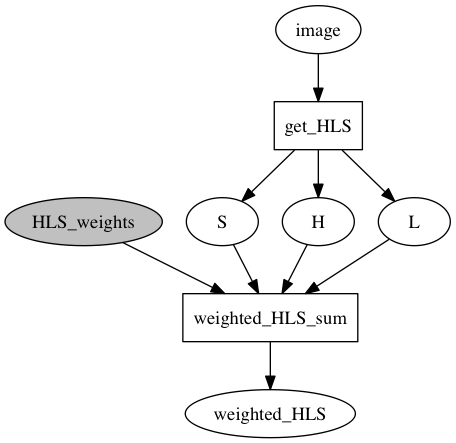

In [8]:
params = {
    'HLS_weights': [0, 0.7, 1.],
}

runner = CompGraphRunner(cg, frozen_tokens=params)

nxpd.draw(runner.token_manager.to_networkx())

In [9]:
runner.run(image=warped_images[1])

S_magn, S_direct = sobel_combo(runner['S'])
S_sobelx = lanelines.scale_image_255( lanelines.sobel_x(runner['S']) )
S_sobely = lanelines.scale_image_255( lanelines.sobel_y(runner['S']) )

## Experiments

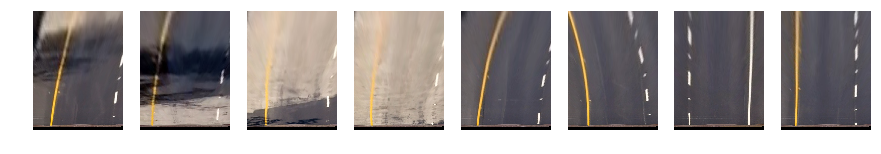

In [10]:
plt.figure(figsize=(15, 5))
for i, wim in enumerate(warped_images):
    plt.subplot(1, 8, i+1)
    plt.imshow( cv2.cvtColor(wim, cv2.COLOR_BGR2RGB) )
    plt.axis('off')

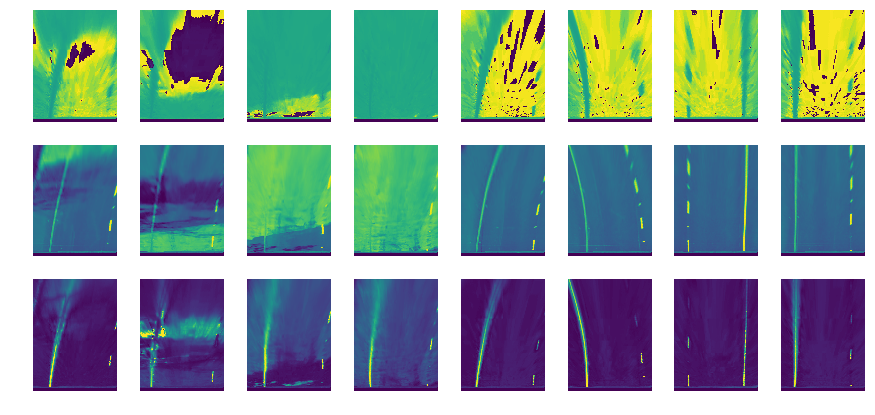

In [11]:
plt.figure(figsize=(15, 7))
for i, wim in enumerate(warped_images):

    H, L, S = get_hls_channels(wim)
    
    plt.subplot(3, 8, i+1)
    plt.imshow( H )
    plt.axis('off')
    
    plt.subplot(3, 8, 8+i+1)
    plt.imshow( L )
    plt.axis('off')
    
    plt.subplot(3, 8, 16+i+1)
    plt.imshow( S )
    plt.axis('off')
    

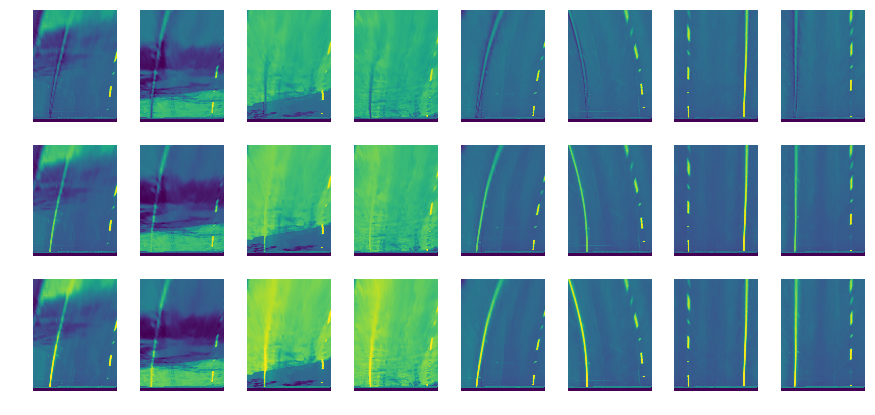

In [12]:
plt.figure(figsize=(15, 7))
for i, wim in enumerate(warped_images):
    
    B = wim[:, :, 0]
    G = wim[:, :, 1]
    R = wim[:, :, 2]
    
    plt.subplot(3, 8, i+1)
    plt.imshow( B )
    plt.axis('off')
    
    plt.subplot(3, 8, 8+i+1)
    plt.imshow( G )
    plt.axis('off')
    
    plt.subplot(3, 8, 16+i+1)
    plt.imshow( R )
    plt.axis('off')
    

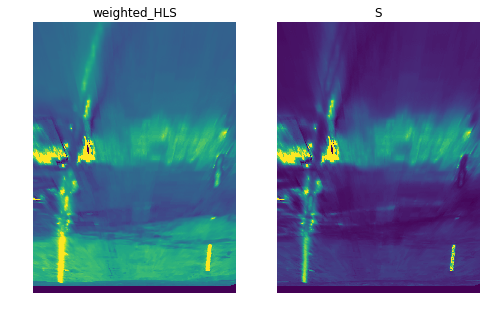

In [13]:
plt.figure(figsize=(8, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(runner['weighted_HLS'])
plt.title('weighted_HLS')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(runner['S'])
plt.title('S')

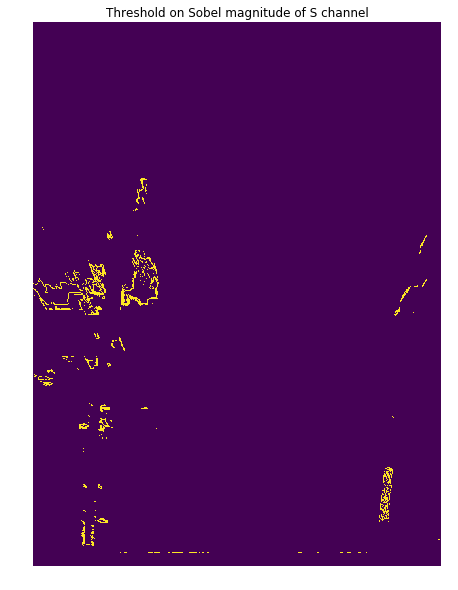

In [14]:
plt.figure(figsize=(8, 10))
plt.axis('off')
plt.imshow( lanelines.mask_threashold_range(S_magn, 40, 100) )
plt.title('Threshold on Sobel magnitude of S channel')

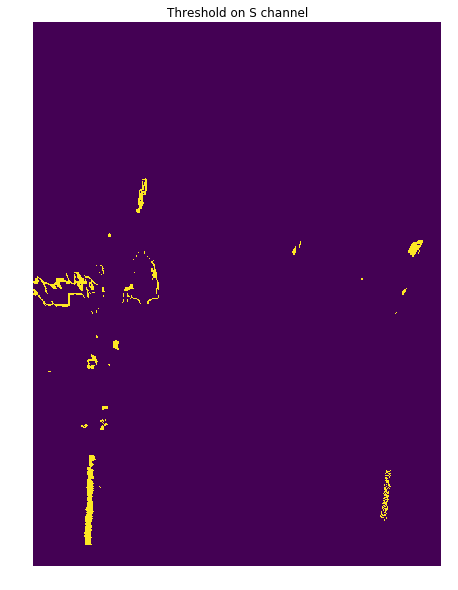

In [15]:
plt.figure(figsize=(8, 10))
plt.axis('off')
plt.imshow( lanelines.mask_threashold_range(runner['S'], 180, 250) )
plt.title('Threshold on S channel')

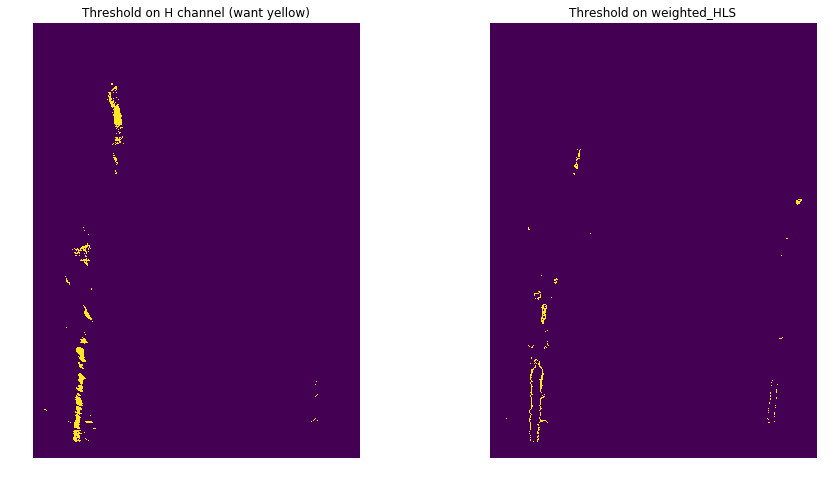

In [16]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow( lanelines.mask_threashold_range(runner['H'], 90, 100) )
plt.title('Threshold on H channel (want yellow)')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow( lanelines.mask_threashold_range(runner['weighted_HLS'], 220, 250) )
plt.title('Threshold on weighted_HLS')

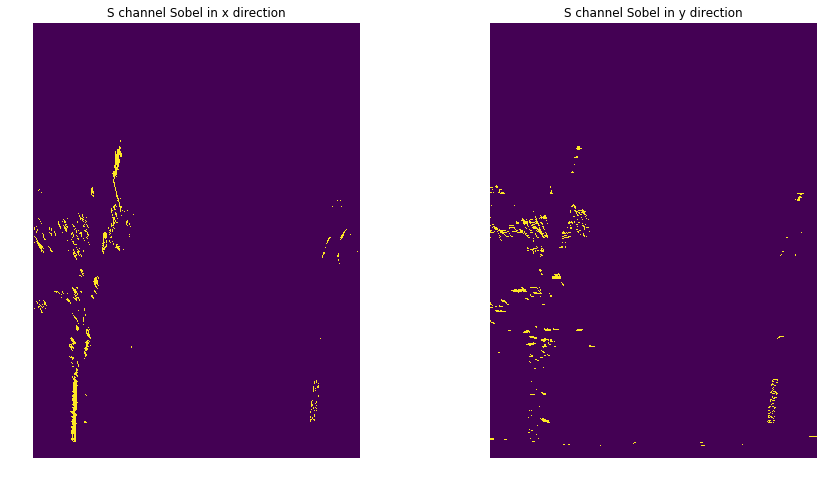

In [17]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow( lanelines.mask_threashold_range(S_sobelx, 20, 60) )
plt.title('S channel Sobel in x direction')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow( lanelines.mask_threashold_range(S_sobely, 20, 100) )
plt.title('S channel Sobel in y direction')

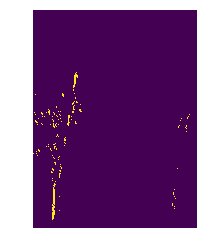

In [18]:
plt.axis('off')
plt.imshow(
    cv2.morphologyEx(lanelines.mask_threashold_range(S_sobelx, 20, 60), cv2.MORPH_OPEN, (3, 3))
)

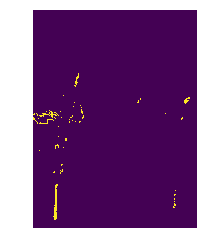

In [19]:
plt.axis('off')
plt.imshow(
    cv2.morphologyEx(lanelines.mask_threashold_range(runner['S'], 180, 250), cv2.MORPH_OPEN, (5, 5))
)

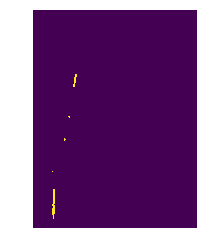

In [20]:
plt.axis('off')
plt.imshow(
    cv2.medianBlur( lanelines.mask_threashold_range(S_sobelx, 20, 60), 11)
)